In [1]:
from collections import defaultdict
from itertools import chain, combinations
from matplotlib import pyplot as plt
import microhapdb
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
all_markers = list(microhapdb.Marker.objectify(microhapdb.markers))
print(len(all_markers))

3053


In [3]:
markers_nonrep = [m for m in all_markers if m.name not in microhapdb.repeats.index]
print(len(markers_nonrep))

1673


In [4]:
short_markers = [m for m in markers_nonrep if (len(m) <= 60 and m.data.Ae > 1.0)]
short_markers.sort(key=lambda m: m.data.Ae, reverse=True)
print(len(short_markers))

164


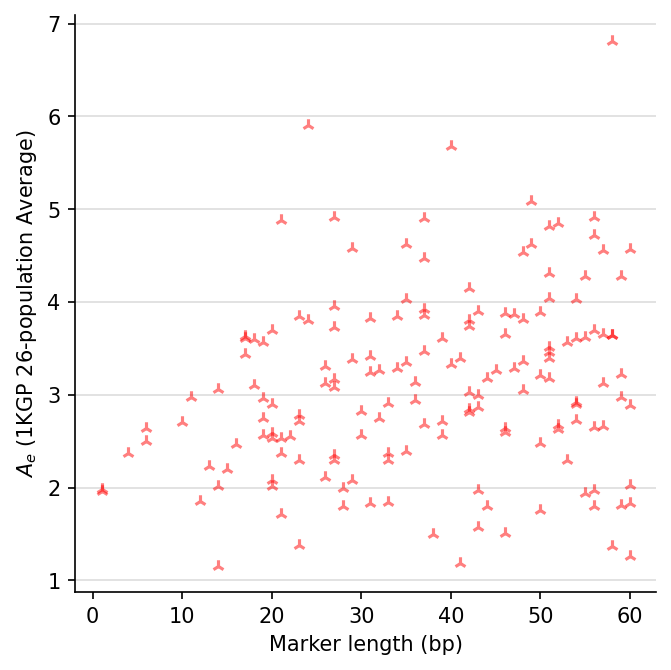

In [5]:
lengths = [len(m) for m in short_markers]
aes = [m.data.Ae for m in short_markers]
plt.figure(figsize=(5, 5), dpi=150)
plt.scatter(lengths, aes, marker="2", color="red", alpha=0.5)
plt.ylabel("$A_e$ (1KGP 26-population Average)")
plt.xlabel("Marker length (bp)")
#plt.legend(loc="upper left")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().yaxis.grid(True, color="#DDDDDD")
plt.gca().set_axisbelow(True)

In [6]:
highest = [m for m in short_markers if m.data.Ae > 5]
microhapdb.markers[microhapdb.markers.Name.isin([m.name for m in highest])]

,Name,NumVars,Extent,Chrom,Start,End,Positions,Positions37,RSIDs,Source,Ae
409,mh02KK-134.v4,3,40,chr2,160222900,160222939,160222900;160222924;160222939,161079411;161079435;161079450,rs12469721;rs3101043;rs3111398,Staadig2021,5.685
1814,mh10WL-042,4,58,chr10,126918899,126918956,126918899;126918909;126918914;126918956,128607468;128607478;128607483;128607525,rs10794140;rs11245233;rs61875476;rs10794141,Yu2022G1,6.815
2471,mh16WL-040.v1,4,24,chr16,8832741,8832764,8832741;8832746;8832747;8832764,8926598;8926603;8926604;8926621,rs9931331;rs12925234;rs12917990;rs12921984,Yu2022G1,5.910
2815,mh19USC-19qA.v3,5,49,chr19,33273772,33273820,33273772;33273786;33273812;33273817;33273820,33764678;33764692;33764718;33764723;33764726,rs10419866;rs12978036;rs10420798;rs11672621;rs...,Yu2022G4,5.084


In [7]:
def build_graphs(markers):
    graphs = defaultdict(nx.Graph)
    chroms = sorted(set([m.chrom for m in markers]))
    for chrom in chroms:
        cmarkers = [m for m in markers if m.chrom == chrom]
        graphs[chrom].add_nodes_from(cmarkers)
        for mh1, mh2 in combinations(graphs[chrom].nodes, 2):
            if abs(mh1.start - mh2.start) >= 10e6:
                graphs[chrom].add_edge(mh1, mh2)
    return graphs

In [8]:
graphs = build_graphs(short_markers)

In [9]:
for chrom, graph in graphs.items():
    print(f"{chrom:>5s}: nodes={graph.number_of_nodes():<3d} edges={graph.number_of_edges()}")

 chr1: nodes=19  edges=156
chr10: nodes=13  edges=69
chr11: nodes=13  edges=67
chr12: nodes=11  edges=49
chr13: nodes=4   edges=6
chr14: nodes=4   edges=4
chr15: nodes=5   edges=8
chr16: nodes=7   edges=18
chr17: nodes=10  edges=35
chr18: nodes=4   edges=5
chr19: nodes=4   edges=4
 chr2: nodes=10  edges=44
chr20: nodes=3   edges=3
chr21: nodes=1   edges=0
chr22: nodes=3   edges=2
 chr3: nodes=5   edges=9
 chr4: nodes=11  edges=46
 chr5: nodes=10  edges=35
 chr6: nodes=7   edges=20
 chr7: nodes=6   edges=13
 chr8: nodes=7   edges=17
 chr9: nodes=3   edges=3
 chrX: nodes=4   edges=6


In [10]:
def clique_agg_ae(clique):
    return sum(marker.data.Ae for marker in clique)

In [11]:
cliques_by_chrom = dict()
best_clique_by_chrom = dict()
for chrom, graph in sorted(graphs.items(), key=lambda cg: cg[1].number_of_edges()):
    cliques = list(nx.find_cliques(graph, nodes=None))
    cliques_by_chrom[chrom] = cliques
    best_clique = sorted(cliques, key=lambda c: clique_agg_ae(c))[-1]
    best_clique_by_chrom[chrom] = best_clique

In [12]:
print(sum([len(c) for c in best_clique_by_chrom.values()]))

104


In [13]:
shorts = set()
for clique in best_clique_by_chrom.values():
    shorts.update(clique)
short_names = sorted([m.name for m in shorts])
print(*short_names, sep="\n")

mh01CP-010
mh01KK-002
mh01KK-211.v2
mh01USC-1pA
mh01USC-1pB
mh01USC-1pD
mh01WL-002.v3
mh01WL-053.v2
mh01WL-110
mh02CP-004
mh02KK-105
mh02KK-134.v4
mh02KK-139
mh02USC-2qB.v1
mh02USC-2qE
mh02WL-028.v2
mh02WL-059
mh02ZBF-002
mh03KK-009
mh03KK-216
mh03LV-06.v3
mh03WL-010
mh04KK-010.v1
mh04KK-013.v4
mh04USC-4qB
mh04USC-4qD
mh04WL-004.v3
mh04WL-047
mh05CP-006
mh05NH-09
mh05USC-5qB
mh05USC-5qD
mh05WL-068
mh05ZBF-001
mh06CP-007
mh06USC-6pA
mh06USC-6qA
mh06WL-041
mh06WL-076
mh06ZBF-001
mh07USC-7pB
mh07USC-7pC
mh07USC-7qA
mh07USC-7qB
mh07ZHA-004.v2
mh08USC-8pA
mh08USC-8pB
mh08USC-8qB
mh08ZBF-002
mh09KK-035.v2
mh09KK-152.v2
mh09USC-9qB
mh0XUSC-XpA
mh0XUSC-XpC
mh0XUSC-XqE
mh0XUSC-XqG
mh10CP-006
mh10KK-085
mh10KK-087
mh10USC-10pB
mh10WL-042
mh10WL-054.v2
mh11CP-005
mh11HYP-29
mh11KK-040
mh11KK-180.v4
mh11NH-19
mh11PK-63643.v1
mh12CP-003
mh12CP-007
mh12USC-12pB
mh12USC-12qA
mh12WL-031.v1
mh12WL-033
mh12WL-034
mh13KK-213.v4
mh13KK-217.v4
mh13KK-225.v4
mh13USC-13qC
mh14USC-14qA
mh14USC-14qC
mh15KK-066

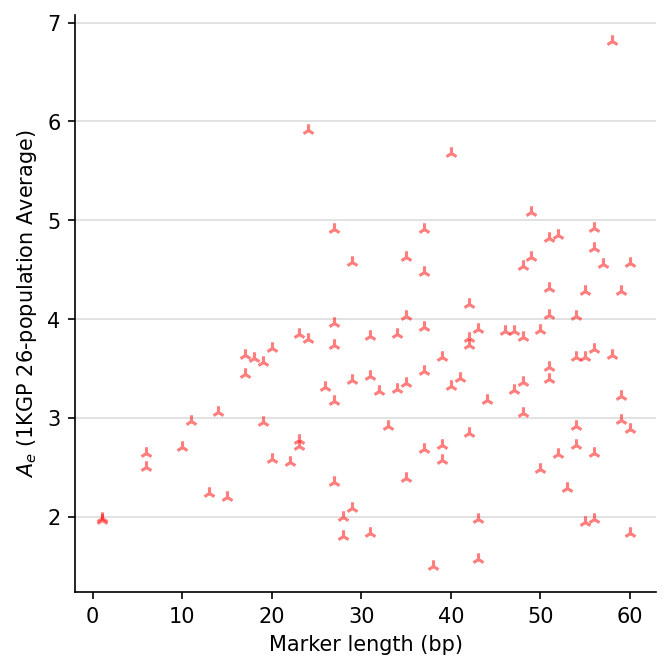

In [14]:
lengths = [len(m) for m in shorts]
aes = [m.data.Ae for m in shorts]
plt.figure(figsize=(5, 5), dpi=150)
plt.scatter(lengths, aes, marker="2", color="red", alpha=0.5)
plt.ylabel("$A_e$ (1KGP 26-population Average)")
plt.xlabel("Marker length (bp)")
#plt.legend(loc="upper left")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().yaxis.grid(True, color="#DDDDDD")
plt.gca().set_axisbelow(True)